In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import datetime as dt
import matplotlib as mpl
import networkx as nx
import scipy.io as sio
import scipy.sparse as sps
from datetime import date, timedelta
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
from matplotlib import rcParams
from importlib import reload
import sys
import seaborn as sns
import scipy
from tqdm import tqdm
from matplotlib.patches import Patch
import utils_comparison as uc
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# plot distribution of cluster sizes

def plot_cluster_size_dist(clusters_A, clusters_B, name_A, name_B, naming):
    clusters_A[naming]=name_A
    clusters_B[naming] = name_B
    clusters = pd.concat([clusters_A, clusters_B])

    sizes_A = pd.DataFrame(clusters_A['size']/clusters_A['size'].sum())
    sizes_A[naming] = name_A

    sizes_B = pd.DataFrame(clusters_B['size']/clusters_B['size'].sum())
    sizes_B[naming] = name_B

    sizes = pd.concat([sizes_A, sizes_B])
    sns.histplot(x='size', hue=naming, multiple='dodge',data=sizes, log_scale= True, palette=['steelblue','indianred'],alpha=.7, bins=15, shrink=0.8)
    plt.xlabel('Cluster sizes [% of observations]')
    plt.savefig(f'K:/XC4/projects/johanna/02_disease_trajectories/paper2/03_clustering/cluster_size_comparison_{name_A}_{name_B}.pdf')

In [3]:
def print_minmax_clusters(clusters, var, max=True):
    if max:
        clusters.sort_values(var, ascending=False, inplace=True)
    else:
        clusters.sort_values(var, ascending=True, inplace=True)

    for i, row in clusters[1:5].iterrows():
        try:
            print(row['order'])
        except:
            print(i)
        print(row[var])
        print(row['size']/clusters['size'].sum())
        print(row['conditions'][['condition','from_ICD','to_ICD']].merge(blocks, how='left', on = ['from_ICD','to_ICD']))

In [4]:
with open('blocks.pkl','rb') as f:
    blocks = pickle.load(f)
clusters_DK = pd.read_csv('clusters_DK.csv')
clusters_AT_replication = pd.read_csv('clusters_AT_replication.csv')
clusters_AT_original = pd.read_csv('clusters_AT_original.csv')

# Comparison of Clusters by Haug et al. 2020 to Replication Attempt

In [5]:
# gather conditions
conditions_replication_true = uc.gather_criteria(clusters_AT_replication)
conditions_original_true = uc.gather_criteria(clusters_AT_original)
conditions_original_true = conditions_original_true.reset_index().drop('index',axis=1)
conditions_replication_false = uc.gather_criteria(clusters_AT_replication,False)
conditions_original_false = uc.gather_criteria(clusters_AT_original,False)
conditions_original_false = conditions_original_false.reset_index().drop('index',axis=1)

In [6]:
# find perfect matches
diffs = np.zeros([132,132])
for i in range(132):
    for j in range(132):
        cond_diff = np.sum(np.abs(conditions_original_true.loc[i,:]- conditions_replication_true.loc[j,:]))
        diffs[i,j]=cond_diff
# perfect matches
perfect_matches = np.where(diffs==0)
perfect_matches = pd.DataFrame([perfect_matches[0],perfect_matches[1]]).T.rename(columns={0:'AT_paper_cluster',1:'AT_cluster_match'})
perfect_matches['diff']='-'
perfect_matches = perfect_matches.drop([0,3],axis=0)
perfect_matches

,AT_paper_cluster,AT_cluster_match,diff
1,0,1,-
2,0,2,-
4,0,4,-
5,0,5,-
6,0,6,-
...,...,...,...
17419,131,127,-
17420,131,128,-
17421,131,129,-
17422,131,130,-


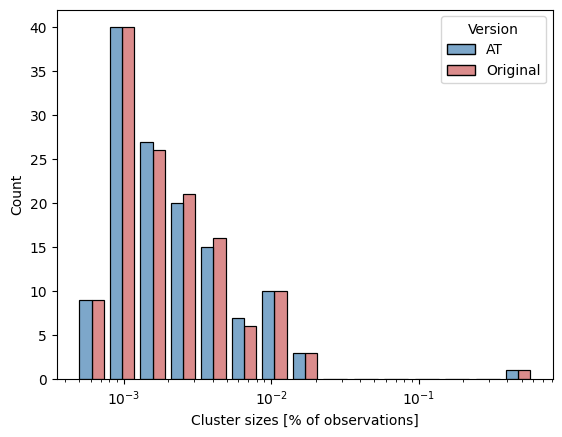

In [7]:
plot_cluster_size_dist(clusters_AT_replication, clusters_AT_original,'AT','Original','Version')

# Compare Cluster Size Distribution in Denmark and Austria

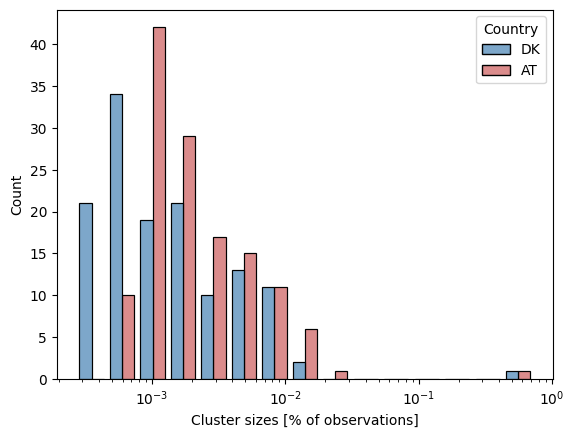

In [8]:
plot_cluster_size_dist(clusters_DK,clusters_AT_original,'DK','AT','Country')


Text(0.5, 0, 'Mean age [years]')

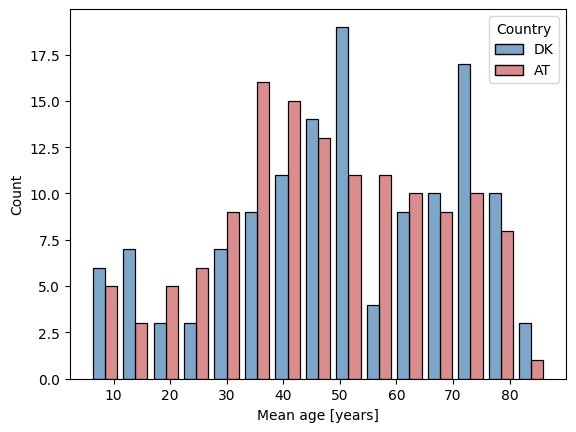

In [10]:
# compare mean cluster age distribution

DK_age_stats = pd.DataFrame(clusters_DK['mean_age']).rename(columns={'mean_age': 'Mean age'})
DK_age_stats['Country'] = 'DK'

AT_age_stats = pd.DataFrame(clusters_AT_original['mean_age']).rename(columns={'mean_age':'Mean age'})
AT_age_stats['Country'] = 'AT'

age_stats = pd.concat([DK_age_stats,AT_age_stats], axis=0)
# plot
sns.histplot(x='Mean age', hue='Country', multiple='dodge',data=age_stats,  palette=['steelblue','indianred'],alpha=.7, bins=15, shrink=0.8)
plt.xlabel('Mean age [years]')

Text(0.5, 0, 'Percentage of females')

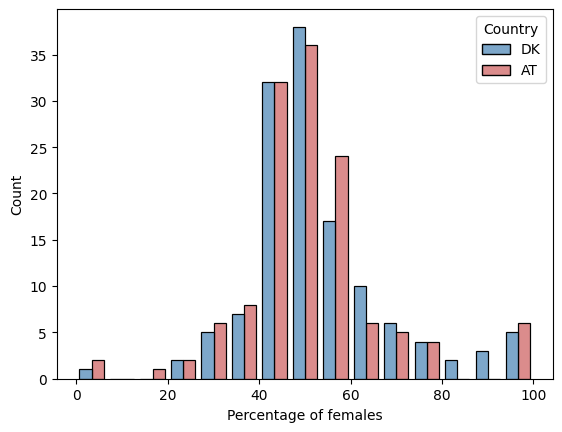

In [11]:
# compare mean cluster female ratio distribution

DK_gender_stats = pd.DataFrame(clusters_DK['female_ratio']).rename(columns={'female_ratio': 'Female ratio'})
DK_gender_stats['Country'] = 'DK'

AT_gender_stats = pd.DataFrame(clusters_AT_original['female_ratio']).rename(columns={'female_ratio':'Female ratio'})
AT_gender_stats['Country'] = 'AT'

gender_stats = pd.concat([DK_gender_stats,AT_gender_stats], axis=0)

gender_stats['Female ratio'] = gender_stats['Female ratio']*100
sns.histplot(x='Female ratio', hue='Country', multiple='dodge',data=gender_stats,  palette=['steelblue','indianred'],alpha=.7, bins=15, shrink=0.8)
plt.xlabel('Percentage of females')

Text(0.5, 0, 'Mortality rates [%]')

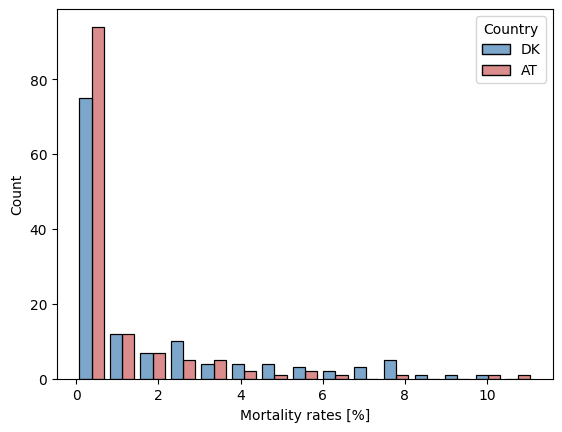

In [12]:
# compare mortality rate distribution


DK_mortality_stats = pd.DataFrame(clusters_DK['mortality_rate']).rename(columns={'mortality_rate': 'Mortality rate'})
DK_mortality_stats['Country'] = 'DK'

AT_mortality_stats = pd.DataFrame(clusters_AT_original['mortality_rate']).rename(columns={'mortality_rate': 'Mortality rate'})
AT_mortality_stats['Country'] = 'AT'

mortality_stats = pd.concat([DK_mortality_stats,AT_mortality_stats], axis=0)

mortality_stats['Mortality rate'] = mortality_stats['Mortality rate']*100

sns.histplot(x='Mortality rate', hue='Country', multiple='dodge',data=mortality_stats,  palette=['steelblue','indianred'],alpha=.7, bins=15, shrink=0.8)
plt.xlabel('Mortality rates [%]')

In [14]:
sizes_A = pd.DataFrame(clusters_DK['size']/clusters_DK['size'].sum())
sizes_A.drop(sizes_A['size'].idxmax(),inplace=True)
sizes_A['Country'] = 'AT'
sizes_B = pd.DataFrame(clusters_AT_original['size']/clusters_AT_original['size'].sum())
sizes_B.drop(sizes_B['size'].idxmax(), inplace=True)

sizes_B['Country'] = 'DK'

sizes = pd.concat([sizes_A, sizes_B])
sizes = sizes.rename(columns={'size':"Size"})

age_stats = age_stats.rename(columns={"Mean age": "Mean Age [years]"})
gender_stats = gender_stats.rename(columns={"Female ratio":"Female Ratio [%]"})
mortality_stats = mortality_stats.rename(columns={'Mortality rate': "Mortality Rate [%]"})
sizes["Size"] = sizes["Size"]*10
sizes = sizes.rename(columns={"Size": "Size [‰]"})

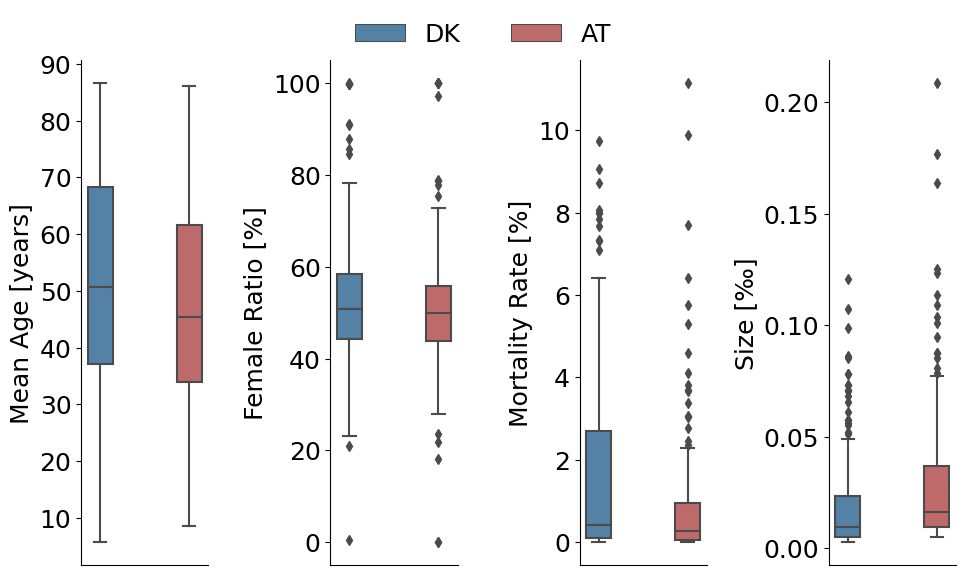

In [15]:
# create boxplot with overview
dfs = [age_stats, gender_stats, mortality_stats, sizes]
plt.rcParams.update({'font.size':18})

fig, axes = plt.subplots(1,4, figsize=(10,6), sharey=False)
for ax, df in zip(axes, dfs):
    sns.boxplot(hue=df.columns[1], y=df.columns[0], x="Country", data= df, palette=['steelblue','indianred'],ax=ax, width=0.8, dodge=True)
    ax.legend_.remove()
    ax.set_xlabel('')
    ax.set_xticks([])
    sns.despine(ax=ax, top=True, right=True)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=2, frameon=False)
plt.tight_layout(rect=[0,0,1,0.95])